# Google Colab Setup

In [0]:
!pip install catboost

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/Car_Pricing_DataSets/'   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libs, Global Funcs & Global Vars setup

In [0]:
import pandas as pd
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import ast # convert string to dict

import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import math

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# allDone - is a sound notification
from IPython.display import Audio, display
sound = 'https://freesound.org/data/previews/29/29589_215874-lq.mp3'
def allDone():
    display(Audio(url=sound, autoplay=True))

# file_path = '/Users/alexander/Documents/DataFactory/Projects/Car_Pricing_DataSets/'

random_state = 42
train_size = 0.8

#MAPE function

def MAPE(y_true, y_pred):
    y_pred = np.around(y_pred,0) 
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# Train sets upload and NaN cleanup

In [0]:
train_set1 = pd.read_csv(file_path + 'train_1.csv')
train_set2 = pd.read_csv(file_path + 'train_2.csv')
train_set = train_set1.append(train_set2, sort=False).reset_index(drop=True)

train_set1.shape, train_set2.shape, train_set.shape

((109080, 22), (57874, 21), (166954, 22))

In [0]:
train_set.drop_duplicates(inplace = True)
train_set.shape

(165325, 22)

In [0]:
# check NaN values
train_set.isna().sum()

Unnamed: 0               56245
bodyType                     1
brand                        0
color                        0
fuelType                     0
modelDate                    1
name                         1
numberOfDoors                1
productionDate               0
vehicleConfiguration         1
engineDisplacement           1
enginePower                  1
description               5277
mileage                      0
Комплектация                 0
Привод                       1
Руль                         0
Владельцы                   11
ПТС                          9
Таможня                      0
Владение                102571
Price                        0
dtype: int64

In [0]:
train_set.dropna(subset=[
    'bodyType', 'modelDate', 'name', 'numberOfDoors', 'vehicleConfiguration',
    'engineDisplacement', 'enginePower','Привод'
], axis=0, inplace = True)

train_set['Владельцы'].fillna(2, inplace = True)
train_set['ПТС'].fillna('ORIGINAL', inplace = True)
train_set['description'].fillna('no_info', inplace = True)
train_set['Владение'].fillna('no_info', inplace = True)
train_set.shape

(165324, 22)

### train_set & test_set merge

In [0]:
test_set = pd.read_csv(file_path + 'test.csv')

In [0]:
train_set['sample'] = 1  # mark the train set
test_set['sample'] = 0  # mark the test set
test_set['Price'] = 0  # define the absent field for the test set as well

df = train_set.append(test_set, sort=False).reset_index(drop=True)

In [0]:
# as the data featuring process takes time due to a high volume of data, a result of previous
# processing was saved and be uploaded

# df = pd.read_csv(file_path + 'car_df_14_05_20.csv')

In [0]:
train_set.columns

Index(['Unnamed: 0', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate',
       'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'engineDisplacement', 'enginePower', 'description', 'mileage',
       'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Таможня',
       'Владение', 'Price', 'sample'],
      dtype='object')

 MERCEDES      22974
VOLKSWAGEN    22644
NISSAN        20777
BMW           20539
TOYOTA        18206
AUDI          13797
MITSUBISHI    12125
SKODA         11327
VOLVO          6213
HONDA          5448
LEXUS          4326
INFINITI       3888
SUZUKI         3060
Name: brand, dtype: int64


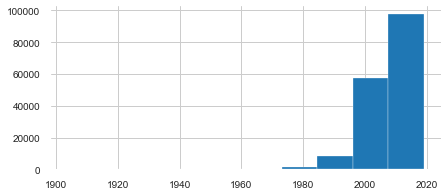

In [0]:
print('',train_set.brand.value_counts())
train_set.modelDate.hist(figsize = (7,3))

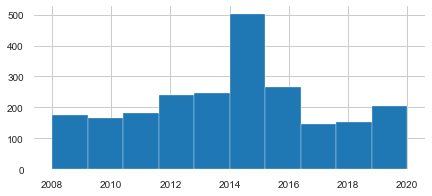

In [0]:
train_set.query(
    'name == "35i 3.0 AT (306 л.с.) 4WD" or name =="30d 3.0d AT (249 л.с.) 4WD" or name == "520i 2.0 AT (184 л.с.)"'
)['productionDate'].hist(figsize = (7,3))

# Features design

In [0]:
df.Владение.fillna('no_info', inplace = True)

def period(data):
    if data == "no_info":
        return -1
    elif "{" in data:
        data = dict(ast.literal_eval(data))
        data = data['month'] + (2020 - data['year'])*12
        return data
    else: 
        data = data.split(' ')
        if "лет" or 'год' in data:
            try:
                return int(data[0])*12 + int(data[3])
            except: 
                return int(data[0])*12
            
df['ownership_period'] = df.Владение.apply(period)

del df['Владение']

In [0]:
del df['Таможня']
del df['Unnamed: 0']
del df['vehicleTransmission']


fuels = {
    "бензин": 1,
    "дизель": 2,
    "гибрид": 3,
    "электро": 4,
    "газ": 5,
    "внедорожник": 6}

df.fuelType = df.fuelType.map(fuels)

"country of origin": Japan = 0 , Germany = 1 , Czech = 2 , Sweden = 3<br>
"EU-JPN": EU = 0, JPN = 1

In [0]:
country = {
    "MERCEDES": 1,
    "VOLKSWAGEN": 1,
    "BMW": 1,
    "NISSAN": 0,
    "TOYOTA": 0,
    "AUDI": 1,
    "MITSUBISHI": 0,
    "SKODA": 2,
    "VOLVO": 3,
    "HONDA": 0,
    "LEXUS": 0,
    "INFINITI": 0,
    "SUZUKI": 0
}

df['country'] = df.brand.map(country)
df['EU-JPN'] = (df['country'] == 0).astype('int32')

In [0]:
# extract "doors" feature and "bodytype"
def doors(bodyType):
    if '2 дв' in bodyType:
        return 2
    elif '3 дв' in bodyType:
        return 3    
    elif '5 дв' in bodyType:
        return 5
    else: 
        return "-1"    
df['doors'] = df['bodyType'].apply(doors)
df['doors'] = df['doors'].astype('int32')

df['body'] = df['bodyType'].apply(lambda x: x.lower().split(' ')[0])
le = LabelEncoder()
le.fit(df.body)
df.body = le.transform(df.body)

del df['bodyType']

In [0]:
le = LabelEncoder()
le.fit(df.brand)
df.brand = le.transform(df.brand)

In [0]:
colors = {
    '040001':'чёрный',
    'FAFBFB':'белый',
    'CACECB':'серебристый',
    '97948F':'серый',
    '0000CC':'синий',
    '200204':'коричневый',
    'EE1D19':'красный',
    '007F00':'зелёный',
    'C49648':'бежевый',
    '22A0F8':'голубой',
    '660099':'пурпурный',
    'DEA522':'золотистый',
    '4A2197':'фиолетовый',
    'FFD600':'жёлтый',
    'FF8649':'оранжевый',
    'FFC0CB':'розовый',
    'чёрный':'чёрный',
    'белый':'белый',
    'синий':'синий',
    'серый':'серый',
    'коричневый':'коричневый',
    'серебристый':'серебристый',
    'красный':'красный',
    'бежевый':'бежевый',
    'голубой':'голубой',
    'зелёный':'зелёный',
    'оранжевый':'оранжевый',
    'золотистый':'золотистый',
    'пурпурный':'пурпурный',
    'фиолетовый':'фиолетовый',
    'жёлтый':'жёлтый'
    }

df.color = df.color.map(colors)

le = LabelEncoder()
le.fit(df.color)
df.color = le.transform(df.color)

In [0]:
# "hourse_power" feature
def hp(name):
    try:
        return int(name.split('(')[1].split(' ')[0])
    except: 
        return '-1'

df['hp'] = df.name.apply(hp)

In [0]:
# "four_weel_driver" feature
def four_wd(name):
    if '4wd' in name.lower():
        return 1
    else: return 0

df['four_wd'] = df.name.apply(four_wd)

In [0]:
df['drive'] = None
df['volume'] = None

for i in range(len(df)):
    try:
        engine = re.search(r'\d\.\d\D', df.name[i]).group(0)
        if 'd' in engine:
            df.drive[i] = 1
        else:
            df.drive[i] = 0
        df.volume[i] = engine[:-1]
    except: 
        df.drive[i] = -1
        df.volume[i] = -1
        
df.drive = df.drive.astype('int32')
df.volume = df.volume.astype('float')

In [0]:
#transmition type
df['transmition'] = 'no_info'

for i in range (len(df.name)):
        df['transmition'][i] = df.name[i].split('(')[0].split(' ')[-2]

le = LabelEncoder()
le.fit(df['transmition'])
df['transmition'] = le.transform(df['transmition'])

In [0]:
#BWM model
df['BMW_type'] = "no_data"
for i in range(len(df)):
    if df['brand'][i] == 'BMW':
        df['BMW_type'][i] = df['name'][i].split(' ')[0]
    else:
        df['BMW_type'][i] = "no_data"
        
#BWM class
df['BMW_class'] = 'no_data'
for i in range(len(df)):
    try:
        df['BMW_class'][i] = re.search(r'\d\d\d', df['BMW_type'][i]).group(0)[0]
    except:
        pass
    
le.fit(df['BMW_type'])
df['BMW_type'] = le.transform(df['BMW_type'])

le.fit(df['BMW_class'])
df['BMW_class'] = le.transform(df['BMW_class'])

del df['name']

In [0]:
#feature age
current_year = 2020
df['age'] = 0 

for i in range(len(df)):
    df['age'][i] = 2020 - df['productionDate'][i]

In [0]:
for i in range(len(df)):
    if 'MECHANICAL' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 0
    elif 'AUTOMATIC' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 1
    elif 'VARIATOR' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 2
    elif 'ROBOT' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 3
    else: 
        df.vehicleConfiguration[i] = -1
        
df.vehicleConfiguration = df.vehicleConfiguration.astype('int64')

In [0]:
# engine_type
# ?probably to be revised
#  letter to be found: h, hyb, LTR, i, e, si, xi, is, L, Li, Ld, other

for i in range(len(df)):
    if 'h' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 1
    elif 'LTR' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 2
    elif 'si' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 3
    elif 'xi' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 4
    elif 'is' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 5    
    elif 'Li' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 6
    elif 'Ld' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 7
    else:
        df['engineDisplacement'][i] = -1

df.engineDisplacement = df.engineDisplacement.astype('int64')

In [0]:
# engine_power
df['n_type'] = 0
for i in range(len(df)):
    if "N" in str(df.enginePower[i]):
        df.enginePower[i] = df.enginePower[i].split(' ')[0]
        df.n_type[i] = 1
    else: 
        pass
    
df.enginePower = df.enginePower.astype('int32')

In [0]:
df.Привод = df.Привод.map({'полный': 0, 'передний': 1, 'задний':2})

df.Руль = df.Руль.map({'LEFT': 0, 'Левый': 0, 'RIGHT':1})

df.ПТС = df.ПТС.map({'ORIGINAL': 0, 'DUPLICATE': 1, 'Оригинал':0, 'Дубликат':1 })

df.Состояние = (df['Состояние'] == 'Не требует ремонта').astype('int32')

# qnnty of owners:
def owners(x):
    x = str(x)
    if  re.search(r'\d\s\w+', x) == None:
        return int(x[0])
    else:
        return int(x.split('в')[0][0])

df.Владельцы.fillna('3', inplace = True)
df.Владельцы = df.Владельцы.apply(owners)

to do: make feature "no description"

In [0]:
features = [
    'AUX', 'Android Auto', 'Bluetooth', 'CarPlay', 'USB',
    'Автоматический корректор фар', 'Адаптивный круиз-контроль',
    'Активная подвеска', 'Активный усилитель руля',
    'Алькантара (Материал салона)', 'Антиблокировочная система (ABS)',
    'Антипробуксовочная система (ASR)', 'Аудиоподготовка', 'Аудиосистема',
    'Аудиосистема Hi-Fi', 'Аудиосистема с TV', 'Аэрография',
    'Беспроводная зарядка для смартфона', 'Блокировка замков задних дверей',
    'Бортовой компьютер', 'Бронированный кузов', 'Велюр (Материал салона)',
    'Вентиляция задних сидений', 'Вентиляция передних сидений',
    'Газобаллонное оборудование', 'Голосовое управление',
    'Датчик давления в шинах', 'Датчик дождя',
    'Датчик проникновения в салон (датчик объема)', 'Датчик света',
    'Датчик усталости водителя', 'Декоративная подсветка салона',
    'Декоративные молдинги', 'Декоративные накладки на педали', 'Диски 14',
    'Диски 15', 'Диски 16', 'Диски 17', 'Диски 18', 'Диски 19', 'Диски 20',
    'Диски 21', 'Диски 22', 'Дистанционный запуск двигателя',
    'Дневные ходовые огни', 'Доводчик дверей', 'Докатка',
    'Запуск двигателя с кнопки', 'Защита картера', 'Иммобилайзер',
    'Искусственная кожа (Материал салона)', 'Камера 360°', 'Камера задняя',
    'Камера передняя', 'Климат-контроль 1-зонный', 'Климат-контроль 2-зонный',
    'Климат-контроль многозонный', 'Кожа (Материал салона)',
    'Количество мест: 2', 'Количество мест: 4', 'Количество мест: 5',
    'Количество мест: 6', 'Количество мест: 7',
    'Комбинированный (Материал салона)', 'Кондиционер',
    'Крепление детского кресла (задний ряд) ISOFIX',
    'Крепление детского кресла (передний ряд) ISOFIX', 'Круиз-контроль',
    'Ксеноновые/Биксеноновые фары', 'Лазерные фары',
    'Ламинированные боковые стекла', 'Легкосплавные диски', 'Люк', 'Металлик',
    'Мультимедиа система для задних пассажиров',
    'Мультифункциональное рулевое колесо', 'Навигационная система',
    'Накладки на пороги', 'Обвес кузова', 'Обогрев рулевого колеса',
    'Омыватель фар', 'Отделка кожей рулевого колеса',
    'Отделка кожей рычага КПП', 'Отделка потолка чёрной тканью',
    'Открытие багажника без помощи рук', 'Охлаждаемый перчаточный ящик',
    'Память передних сидений', 'Память сиденья водителя',
    'Панорамная крыша / лобовое стекло', 'Парктроник задний',
    'Парктроник передний', 'Передний центральный подлокотник',
    'Пневмоподвеска', 'Подогрев задних сидений', 'Подогрев передних сидений',
    'Подрулевые лепестки переключения передач',
    'Подушка безопасности водителя',
    'Подушка безопасности для защиты коленей водителя',
    'Подушка безопасности пассажира', 'Подушки безопасности боковые',
    'Подушки безопасности боковые задние',
    'Подушки безопасности оконные (шторки)', 'Полноразмерное запасное колесо',
    'Прикуриватель и пепельница', 'Программируемый предпусковой отопитель',
    'Проекционный дисплей', 'Противотуманные фары',
    'Регулировка передних сидений по высоте', 'Регулировка руля по вылету',
    'Регулировка руля по высоте', 'Регулировка сиденья водителя по высоте',
    'Регулируемый педальный узел', 'Рейлинги на крыше', 'Розетка 12V',
    'Розетка 220V', 'Рулевая колонка с памятью положения', 'Светлый салон',
    'Светодиодные фары', 'Сигнализация', 'Сигнализация с обратной связью',
    'Сиденья с массажем', 'Система «старт-стоп»',
    'Система автоматической парковки', 'Система адаптивного освещения',
    'Система выбора режима движения', 'Система доступа без ключа',
    'Система контроля за полосой движения', 'Система контроля слепых зон',
    'Система ночного видения', 'Система помощи при спуске',
    'Система помощи при старте в гору (HSA)',
    'Система помощи при торможении (BAS, EBD)',
    'Система предотвращения столкновения',
    'Система распознавания дорожных знаков', 'Система стабилизации (ESP)',
    'Система стабилизации рулевого управления (VSM)',
    'Система управления дальним светом',
    'Складной столик на спинках передних сидений',
    'Складывающееся заднее сиденье', 'Солнцезащитная шторка на заднем стекле',
    'Солнцезащитные шторки в задних дверях', 'Спортивная подвеска',
    'Спортивные передние сиденья', 'Стальные диски', 'Ткань (Материал салона)',
    'Тонированные стекла', 'Третий задний подголовник', 'Третий ряд сидений',
    'Тёмный салон', 'Усилитель руля', 'Фаркоп',
    'Функция складывания спинки сиденья пассажира', 'Центральный замок',
    'ЭРА-ГЛОНАСС', 'Электронная приборная панель',
    'Электрообогрев боковых зеркал', 'Электрообогрев зоны стеклоочистителей',
    'Электрообогрев лобового стекла',
    'Электрообогрев форсунок стеклоомывателей', 'Электропривод зеркал',
    'Электропривод крышки багажника', 'Электрорегулировка задних сидений',
    'Электрорегулировка передних сидений', 'Электрорегулировка руля',
    'Электрорегулировка сиденья водителя', 'Электроскладывание зеркал',
    'Электростеклоподъёмники задние', 'Электростеклоподъёмники передние',
    'Яндекс.Авто'
]

def find_item(features, item):
    features.find(item)
    if features.find(item) > 0:
        return 1
    else: 
        return 0

for item in features:
    df[item] = df['Комплектация'].apply(find_item, item = item)

del df['Комплектация']

In [0]:
df.to_csv(file_path + 'df_features.csv', index = False)

#  Modeling

In [0]:
df = pd.read_csv(file_path + 'df_features.csv')
del df['id']

X = df.query('sample == 1').drop(['sample', 'Price', 'description'], axis=1)
y = df.query('sample == 1')['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

kaggle_X = df.query('sample == 0').drop(['sample', 'Price', 'description'], axis=1)

## Linear Regression (not used in this version)

In [0]:
def lin_reg(X, y):
  X = X.to_numpy()
  y = y.to_numpy()
  return LinearRegression().fit(X, y)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

reg_model = lin_reg(X_train, y_train)
print('MAPE: ', MAPE(y_test, reg_model.predict(X_test)))

MAPE:  74.43302913048353


## XGBoost

### XGBoost baseline

In [0]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 200,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=-1,
                                silent=1)

xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)

CPU times: user 6min 56s, sys: 2.15 s, total: 6min 58s
Wall time: 1min 54s


MAPE:  17.036184668540955
RMSE:  460674.0166797521


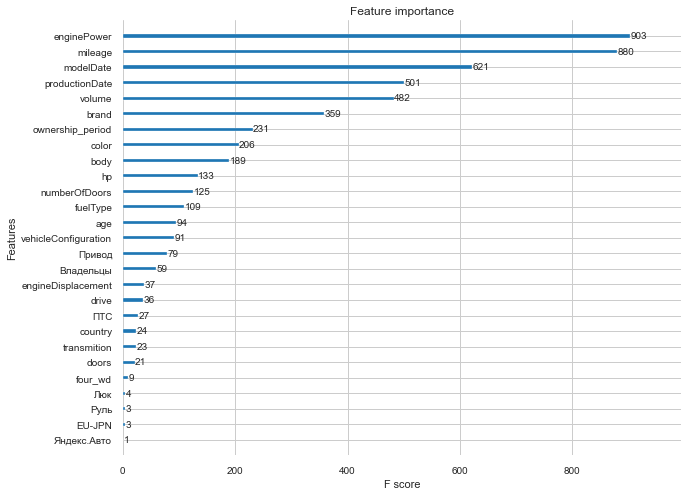

In [0]:
print("MAPE: ", MAPE(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))

xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [8, 18]
plt.show()

### XGBoost model improvement

#### n_estimators tuning

In [0]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

X = df.query('sample == 1').drop(['sample', 'Price', 'description'], axis=1)
y = df.query('sample == 1')['Price']

random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

def xgb_model_train(n_estimators):
    xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                                    learning_rate = 0.1,
                                    max_depth = 5,
                                    alpha = 10,
                                    n_estimators = n_estimators,
                                    min_child_weight = 1,
                                    gamma = 0,
                                    subsample = 0.8,
                                    colsample_bytree=0.8,
                                    scale_pos_weight = 1, 
                                    seed = random_state,

                                    nthread=-1,
                                    silent=1)
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    print("n_estimators: ", n_estimators)
    print("MAPE: ", MAPE(y_test, y_pred))
    print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))   
    return

for n_estimators in range(300, 3500, 500):
    xgb_model_train(n_estimators)
    
allDone()

n_estimators:  300
MAPE:  16.44345074892044
RMSE:  428082.7112405894
n_estimators:  800
MAPE:  14.795021712779999
RMSE:  414679.17449447763
n_estimators:  1300
MAPE:  14.273104071617126
RMSE:  411482.4858066879
n_estimators:  1800
MAPE:  13.993574678897858
RMSE:  410308.8011349818
n_estimators:  2300
MAPE:  13.819056749343872
RMSE:  410519.3004646956
n_estimators:  2800
MAPE:  13.713741302490234
RMSE:  409187.5599454386
n_estimators:  3300
MAPE:  13.60560953617096
RMSE:  411152.85589997744


CPU times: user 4h 45min 5s, sys: 44.6 s, total: 4h 45min 49s
Wall time: 1h 17min 6s


#### max_depth & min_child_weight tuning

In [0]:
%%time
param_test2 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)}

gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 2300,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test2,
                        scoring='neg_root_mean_squared_error')

gsearch2.fit(X_train,y_train)

print('RMSE: ', -max(gsearch2.cv_results_['mean_test_score']))
index = gsearch2.cv_results_['mean_test_score'].tolist().index(max(gsearch2.cv_results_['mean_test_score']))
print('params: ', gsearch2.cv_results_['params'][index])
pd.Series(gsearch2.cv_results_['mean_test_score']).plot()

allDone()

best option is: max_depth = 5 & min_child_weight = 1<br>

#### gamma tuning (Failed)

[22:09:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

CPU times: user 18h 2min 3s, sys: 4min 15s, total: 18h 6min 18s
Wall time: 5h 10min 17s


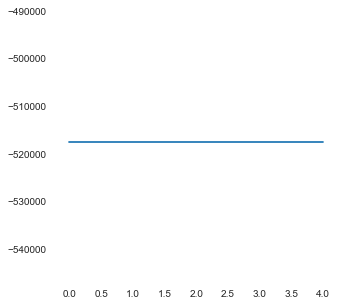

In [0]:
%%time
from sklearn.model_selection import GridSearchCV

param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 2300,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=0),
                        param_grid = param_test3,
                        scoring='neg_root_mean_squared_error')

gsearch3.fit(X_train,y_train)

print('RMSE: ', -max(gsearch3.cv_results_['mean_test_score']))
index = gsearch3.cv_results_['mean_test_score'].tolist().index(max(gsearch3.cv_results_['mean_test_score']))
print('params: ', gsearch3.cv_results_['params'][index])
pd.Series(gsearch3.cv_results_['mean_test_score']).plot()

allDone()

#### subsample & colsample_bytree tuning

RMSE:  523230.56172694033
params:  {'colsample_bytree': 0.92, 'subsample': 0.98}


CPU times: user 5h 26min 44s, sys: 1min 31s, total: 5h 28min 16s
Wall time: 1h 36min 30s


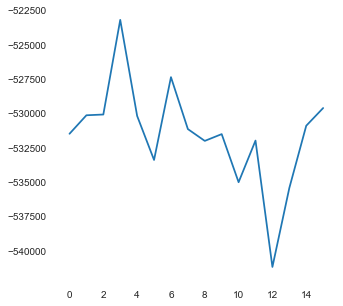

In [0]:
%%time
param_test4 = {
 'subsample':[0.92, 0.94, 0.96, 0.98],
 'colsample_bytree':[0.92, 0.94, 0.96, 0.98]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 200,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test4,
                        scoring='neg_root_mean_squared_error')

gsearch4.fit(X_train,y_train)

print('RMSE: ', -max(gsearch4.cv_results_['mean_test_score']))
index = gsearch4.cv_results_['mean_test_score'].tolist().index(max(gsearch4.cv_results_['mean_test_score']))
print('params: ', gsearch4.cv_results_['params'][index])
pd.Series(gsearch4.cv_results_['mean_test_score']).plot()

allDone()

RMSE:  521939.68754435953
params:  {'colsample_bytree': 0.94, 'subsample': 0.99}
CPU times: user 2h 3min 5s, sys: 32.2 s, total: 2h 3min 37s
Wall time: 34min 36s


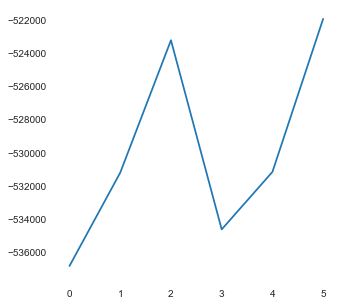

In [0]:
%%time
param_test4 = {
 'subsample':[0.98, 0.99],
 'colsample_bytree':[0.91, 0.92, 0.94]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 200,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test4,
                        scoring='neg_root_mean_squared_error')

gsearch4.fit(X_train,y_train)

print('RMSE: ', -max(gsearch4.cv_results_['mean_test_score']))
index = gsearch4.cv_results_['mean_test_score'].tolist().index(max(gsearch4.cv_results_['mean_test_score']))
print('params: ', gsearch4.cv_results_['params'][index])
pd.Series(gsearch4.cv_results_['mean_test_score']).plot()

#### tuning Regularization Parameters

RMSE:  504690.8928702511
params:  {'colsample_bytree': 0.94, 'subsample': 0.99}
CPU times: user 23h 17min 33s, sys: 6min 5s, total: 23h 23min 38s
Wall time: 6h 58min 29s


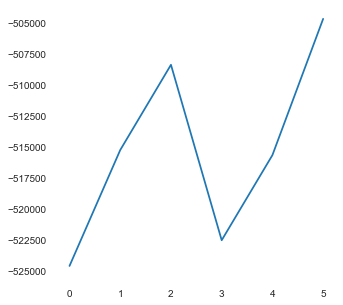

In [0]:
%%time
param_test5 = {
 'subsample':[0.98, 0.99],
 'colsample_bytree':[0.91, 0.92, 0.94]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 2300,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.99,
                                colsample_bytree=0.94,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test5,
                        scoring='neg_root_mean_squared_error')

gsearch5.fit(X_train,y_train)

print('RMSE: ', -max(gsearch5.cv_results_['mean_test_score']))
index = gsearch5.cv_results_['mean_test_score'].tolist().index(max(gsearch5.cv_results_['mean_test_score']))
print('params: ', gsearch5.cv_results_['params'][index])
pd.Series(gsearch5.cv_results_['mean_test_score']).plot()

#### learning_rate tuning

learning_rate 0.01, 0.05, 0.09 didn't bring an MAPE improvement so keep  learning_rate = 0.1

### XGB_model folding

#### "best parametrs" model

In [0]:
xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                                    learning_rate = 0.1,
                                    max_depth = 5,
                                    alpha = 10,
                                    n_estimators = 27000,
                                    min_child_weight = 1,
                                    gamma = 0,
                                    subsample = 0.98,
                                    colsample_bytree=0.92,
                                    scale_pos_weight = 1, 
                                    seed = random_state,
                                    
                                    tree_method='gpu_hist',
                                    gpu_id=0, 
                                 
                                    nthread=-1,
                                    silent=0
                             )

In [0]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

#model = xgb(X_train,y_train)
xgb = xgb_model.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print("MAPE: ", MAPE(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))   

allDone()

#### xgb_folding

In [0]:
def xgb_folding(N_FOLDS, xgb_model, X, y, df_models_result, kaggle_X, df_kaggle, silent = False):
    # N_FOLDS - folds quantity
    # xgb_model - xgb model params
    # X, y - train dataset
    # df_models_result - df to collect 'y'
    # kaggle_X - kaggle data to submit
    # df_kaggle - df to collent Kaggle data for submition
    # silent - if True, the function prints intermediate results for each fold
    
    score_ls = []
    splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(X, y))

    for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS):

        # use the indexes to extract the folds in the train and validation data
        X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

        # model for this fold
        xgb = xgb_model.fit(X_train,y_train)

        # score model on test
        test_predict = xgb.predict(X_test)
        test_score = MAPE(y_test, test_predict)
        score_ls.append(test_score)
        print(f"{idx+1} Fold Test MAPE: {MAPE(y_test, test_predict):0.3f}")

        df_models_result[f'xgb_{idx+1}'] = xgb.predict(X)
        #model.save_model(f'catboost_fold_{idx+1}.model')
        
        if silent == False:
            print(f'Mean Score: {np.mean(score_ls):0.3f}')
            print(f'Std Score: {np.std(score_ls):0.4f}')
            print(f'Max Score: {np.max(score_ls):0.3f}')
            print(f'Min Score: {np.min(score_ls):0.3f}')
        
        df_kaggle[f'kaggle_xgb_{idx+1}'] = xgb.predict(kaggle_X)
    
    return df_models_result, df_kaggle  

## CatBoost folding

### CatBoost BaseModel

In [0]:
model = CatBoostRegressor(
                          # iterations = ITERATIONS,
                          # learning_rate = LR,
                          random_seed = random_state,
                          eval_metric='MAPE',
                          custom_metric=[
                                        #  'R2',
                                         'MAE'],
                          # l2_leaf_reg = 3, #l2 regularisation. To be increased if overfitting (3 - default)
                          # baggin_temperature = 1,
                          task_type="GPU",
                          devices='0:1'
                          ) 

model.fit(X_train, y_train,
         #cat_features=cat_features,
         #logging_level = 'Info',
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         early_stopping_rounds = 1000,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.153879
0:	learn: 1.2307826	test: 1.2451781	best: 1.2451781 (0)	total: 17.5ms	remaining: 17.5s
999:	learn: 0.1495369	test: 0.1577218	best: 0.1576733 (979)	total: 12.4s	remaining: 0us
bestTest = 0.1576733181
bestIteration = 979
Shrink model to first 980 iterations.


### CatBoost Folding

In [0]:
def CatBoost_model(y_train, X_train, X_test, y_test):

    ITERATIONS = 80000
    LR         = 0.1
    depth = 10
    l2_leaf_reg = 3
    
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              random_seed = random_state,
                              eval_metric='MAPE',
                              custom_metric=[
                                            #  'R2',
                                             'MAE'],
                              depth = depth,
                              l2_leaf_reg = l2_leaf_reg,
                              max_ctr_complexity = 1,
                              task_type = 'GPU'

                              # save_snapshot = True,
                              # snapshot_file = file_path + "cat_boost_fit_data_15k_LR05_d15_l2_3",
                          )
    model.fit(X_train, y_train,
             #cat_features=cat_features,
             eval_set=(X_test, y_test),
              verbose_eval=10000,
             use_best_model=True,
             #plot=True
             )
                   
    return model

In [0]:
from sklearn.model_selection import KFold
from tqdm import tqdm
    
def CatBoost_folding(N_FOLDS, X, y, df_models_result, kaggle_X, df_kaggle, silent = False):
    # N_FOLDS = folds quantity
    # X, y - train dataset
    # df_models_result - df to collect 'y'
    # kaggle_X - kaggle data to submit
    # df_kaggle - df to collent Kaggle data for submition
    # silent - if True, the function prints intermediate results for each fold
    
    score_ls = []
    splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(X, y))

    for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS):

        # use the indexes to extract the folds in the train and validation data
        X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

        # model for this fold
        model = CatBoost_model(y_train, X_train, X_test, y_test)

        # score model on test
        test_predict = model.predict(X_test)
        test_score = MAPE(y_test, test_predict)
        score_ls.append(test_score)
        print(f"{idx+1} Fold Test MAPE: {MAPE(y_test, test_predict):0.3f}")

        df_models_result[f'CatBoost_{idx+1}'] = model.predict(X)
        #model.save_model(f'catboost_fold_{idx+1}.model')

        if silent == False:   
            print(f'Mean Score: {np.mean(score_ls):0.3f}')
            print(f'Std Score: {np.std(score_ls):0.4f}')
            print(f'Max Score: {np.max(score_ls):0.3f}')
            print(f'Min Score: {np.min(score_ls):0.3f}')
        
        df_kaggle[f'kaggle_CatBoost_{idx+1}'] = model.predict(kaggle_X)
    
    return df_models_result, df_kaggle  

## Models (features) blending

In [0]:
# function blends (min/mean) all metafeatures
def blending(df, metrics = True):
  xgb = []
  for i in df.columns:
      if "xgb" in i:
          xgb.append(i)

  df['xgb_min'] = df[xgb].min(axis = 1)
  df['xgb_mean'] = df[xgb].mean(axis = 1)

  Cat = []
  for i in df.columns:
      if "Cat" in i:
          Cat.append(i)

  df['Cat_min'] = df[Cat].min(axis = 1)
  df['Cat_mean'] = df[Cat].mean(axis = 1)

  df['total_min'] = df.min(axis = 1)
  df['total_mean'] = df.mean(axis = 1)

  print ('blending is done...')
  
  if metrics == True:
    print("MAPE_cat_mean: ", MAPE(y, df['Cat_mean']))
    print("MAPE_cat_min: ", MAPE(y, df['Cat_min']))
    print('  ')
    print("MAPE_xgb_mean: ", MAPE(y, df['xgb_mean']))
    print("MAPE_xgb_min: ", MAPE(y, df['xgb_min']))
    print('  ')
    print("MAPE_total_mean: ", MAPE(y, df['total_mean']))
    print("MAPE_total_min: ", MAPE(y, df['total_min']))
  
  return df

#### meta_feature preparation & blending

In [0]:
# Df to record predictions for diferent models and Folds
df_models_result = pd.DataFrame(index=y.index)

# df to record predictions for Kaggle dataset
df_kaggle = pd.DataFrame() 

print('XGB calculation...')
df_models_result, df_kaggle = xgb_folding(N_FOLDS, xgb_model, X, y, df_models_result, kaggle_X, df_kaggle)

In [0]:
# save / read XGB calculation

#  df_kaggle.to_csv(file_path + 'df_kaggle_220520.csv', index = False)
#  df_models_result.to_csv(file_path + 'df_models_result_220520.csv', index = False)

df_kaggle = pd.read_csv(file_path + 'df_kaggle_220520.csv')
df_models_result = pd.read_csv(file_path + 'df_models_result_220520.csv')

In [0]:
# df = pd.DataFrame()
N_FOLDS = 3

df_models_result, df_kaggle = CatBoost_folding(N_FOLDS, X, y, df_models_result, kaggle_X, df_kaggle, silent = True)
df_models_result = blending(df_models_result)
df_kaggle = blending(df_kaggle, metrics = False)
allDone()

NameError: ignored

### Kaggle file compilator

In [0]:
#Kaggle file compilator
def kaggle_file(DataSeries, file_name):
  kaggle_file = pd.DataFrame()
  kaggle_file['price'] = DataSeries
  kaggle_file['price'] = kaggle_file['price'].round()
  kaggle_file.rename_axis('id', inplace=True)
  kaggle_file.to_csv(file_path + file_name, index = True)
  kaggle_file = pd.DataFrame()
  print('kaggle_file is compiled...')
  return kaggle_file

In [0]:
kaggle_file(df_kaggle['total_mean'], 'total_mean_250520_v1000.csv')

kaggle_file is compiled...


""
